In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_validate, train_test_split, cross_val_score)
from sklearn.metrics import make_scorer,recall_score
from sklearn.feature_selection import RFECV, SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    RocCurveDisplay,
    classification_report,
    confusion_matrix,
    make_scorer,
    recall_score,
    plot_roc_curve,
    roc_auc_score,
    roc_curve,
    auc
)

from time import time
import warnings
plt.rc('font', family='NanumGothic')
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_submit = pd.read_csv('data/sample_submission.csv')

In [3]:
df_train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


In [7]:
df_train.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000
mean,7651.500000,41.417708,0.049726,0.023327,89.039853,28.112721,0.041296
std,4418.028595,21.444673,0.217384,0.150946,25.476102,6.722315,0.198981
min,0.000000,0.080000,0.000000,0.000000,55.220000,10.300000,0.000000
25%,3825.750000,26.000000,0.000000,0.000000,74.900000,23.500000,0.000000
50%,7651.500000,43.000000,0.000000,0.000000,85.120000,27.600000,0.000000
75%,11477.250000,57.000000,0.000000,0.000000,96.980000,32.000000,0.000000
max,15303.000000,82.000000,1.000000,1.000000,267.600000,80.100000,1.000000


## stroke 원인  
- 고혈압 hypertension (High Blood Pressure)
- 흡연 여부 smoking_status
- 비만 여부 bmi
- 당뇨 여부 avg_glucose_level
- 심혈관 질환 여부 heart_disease

## Features
- gender : 'Male', 'Female', 'Other' -> labeling
- age : numeric
- hypertension : 0(X), 1(O)
- heart_disease : 0(X), 1(O)
- ever_married : 'No', 'Yes' -> labeling
- work_type : 'children', 'Govt_jov', 'Never_worked', 'Private', 'Self-employed'
- Residence_type : 'Rural', 'Urban'
- avg_glucose_level : numeric
- bmi : numeric
- smoking_status ; 'formerly smoked', 'never smoked', 'smokes', 'Unknown' -> labeling(0 or 1?)
- stroke : 0(X), 1(O)

## EDA

stroke 데이터의 불균형 매우 심함

Text(0.5, 1.0, 'stroke')

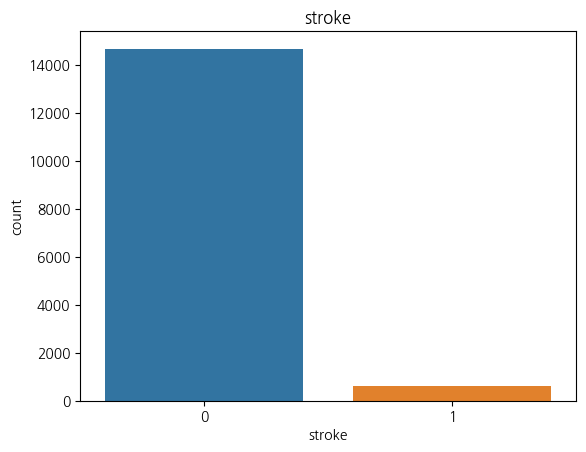

In [8]:
sns.countplot(x='stroke', data=df_train)
plt.title('stroke')

In [5]:
num_features = ['age', 'avg_glucose_level', 'bmi']
cat_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

avg_glucose_level, bmi의 데이터 편향이 있음

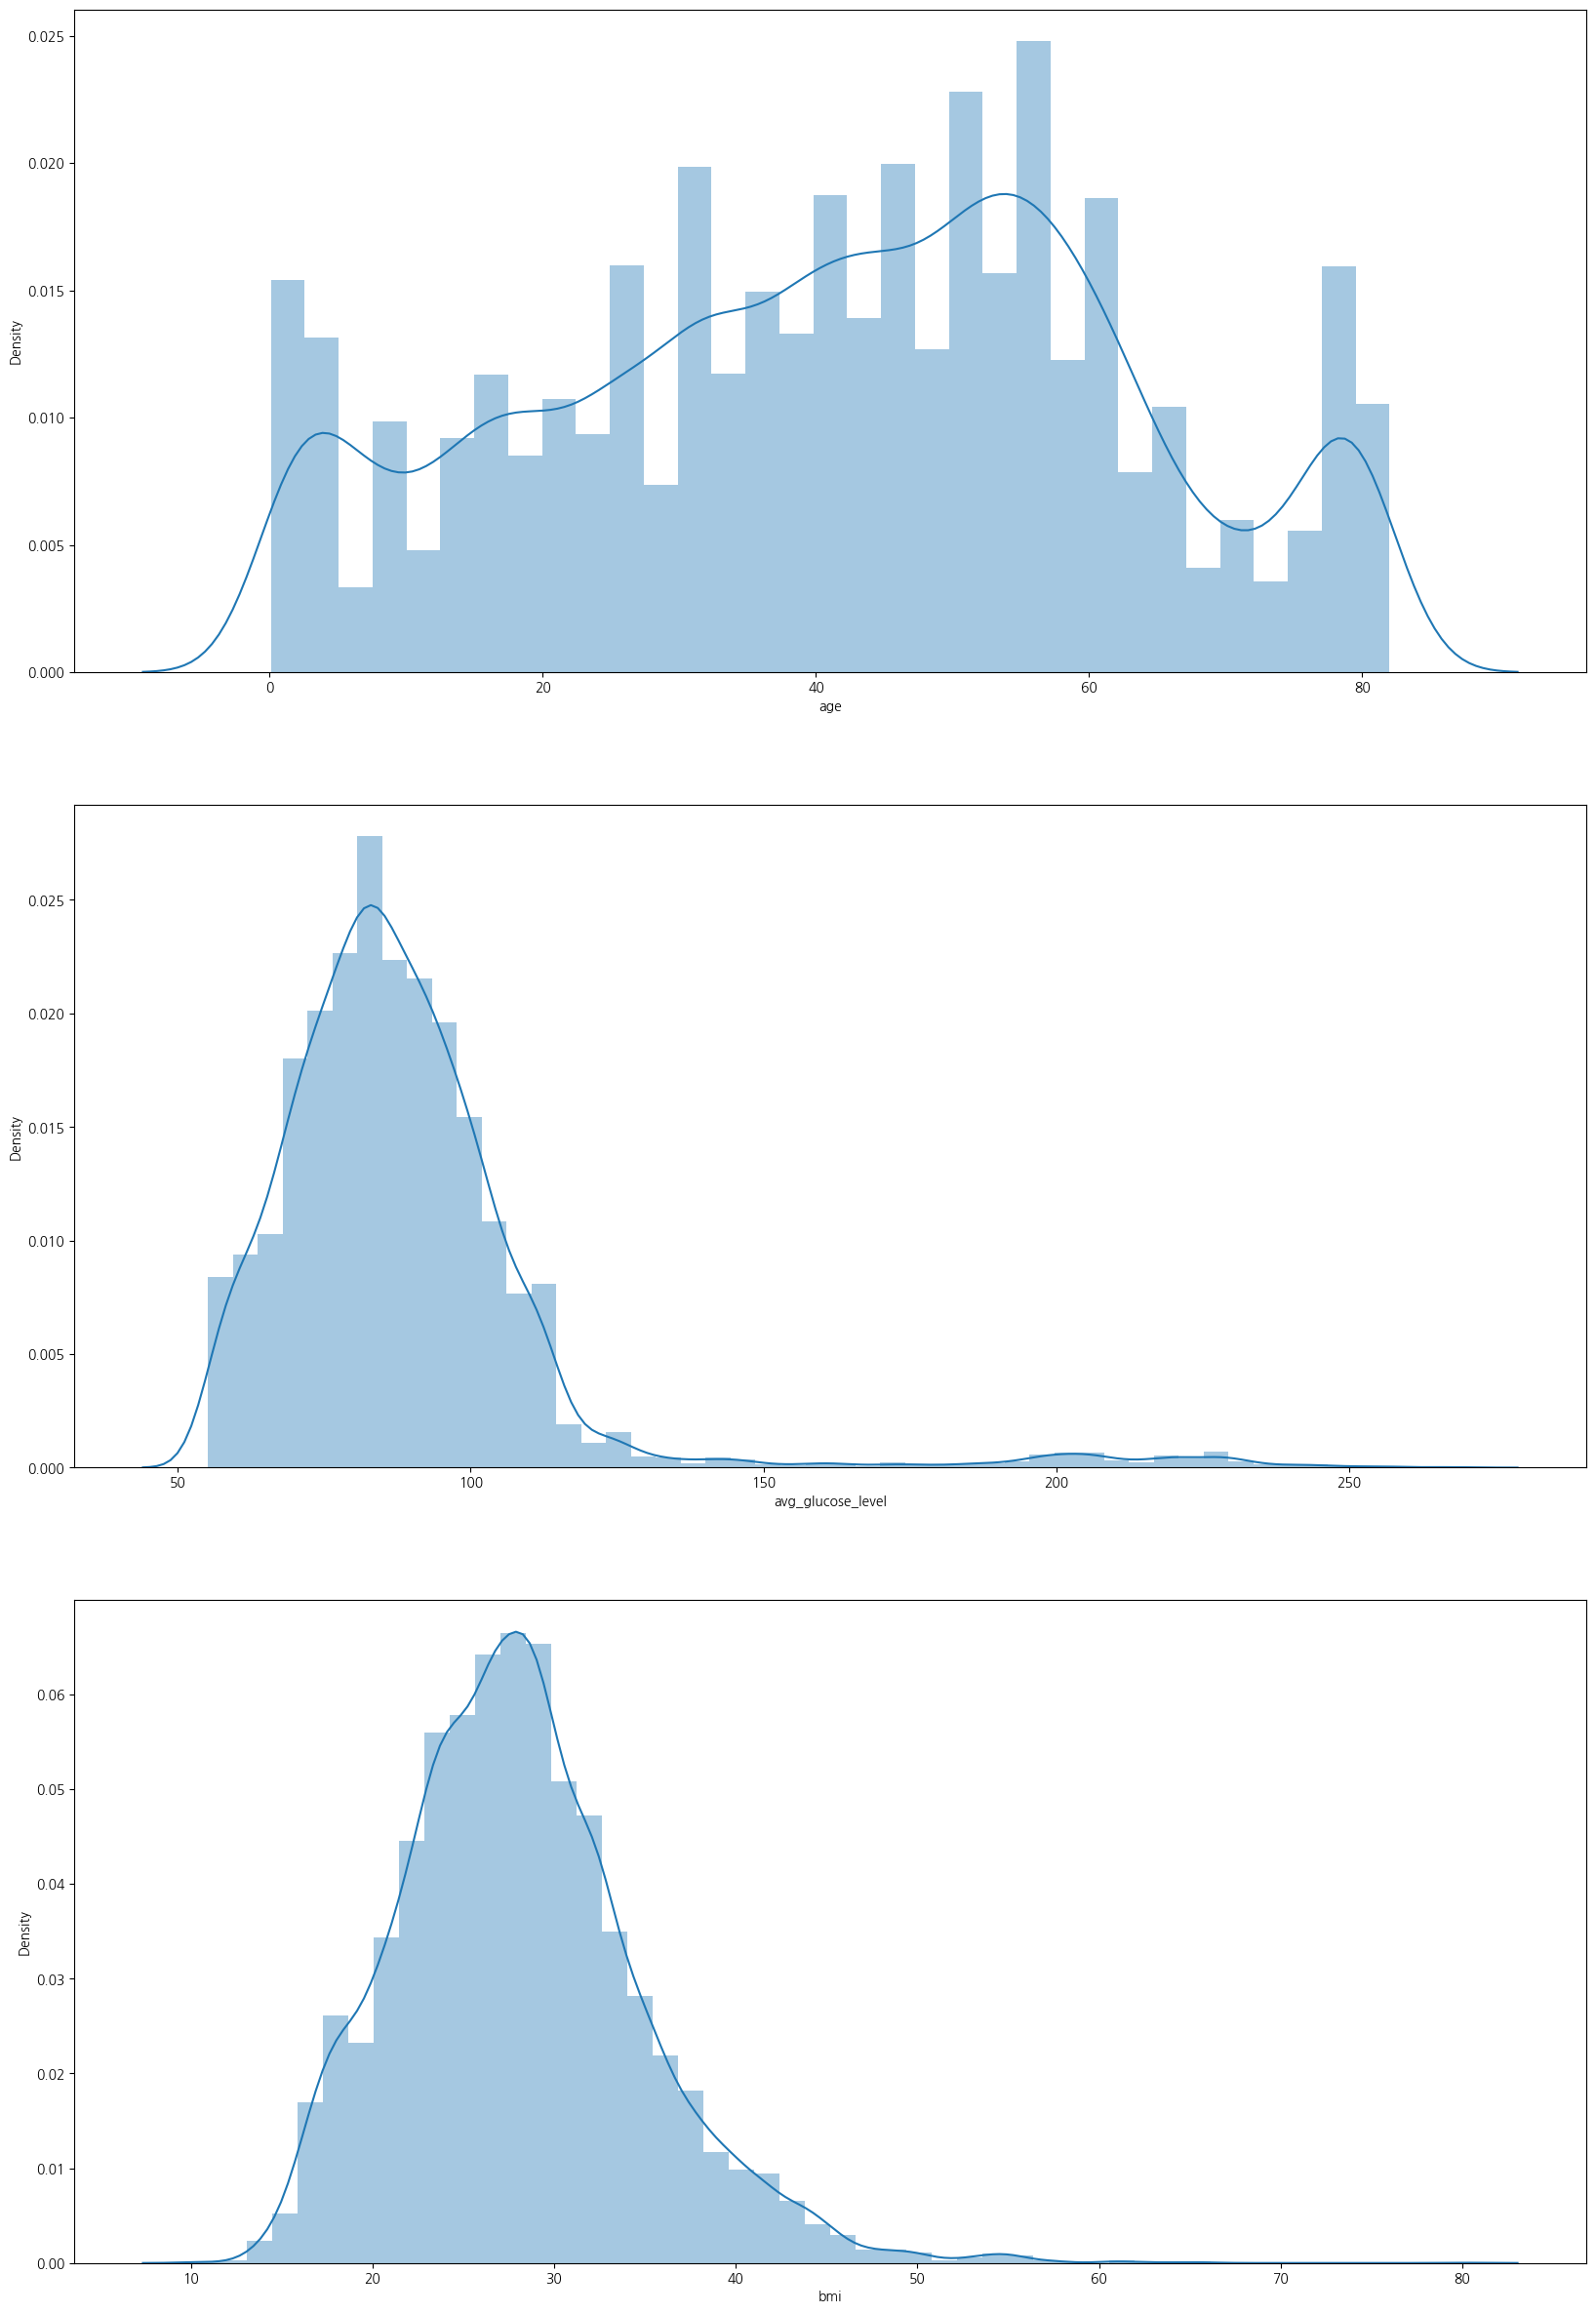

In [6]:
plt.figure(figsize=(20,30))
for idx, feat in enumerate(num_features):
    plt.subplot(3,1,idx+1)
    sns.distplot(df_train[feat])

age 높은 사람들에서 stroke 다수 발생

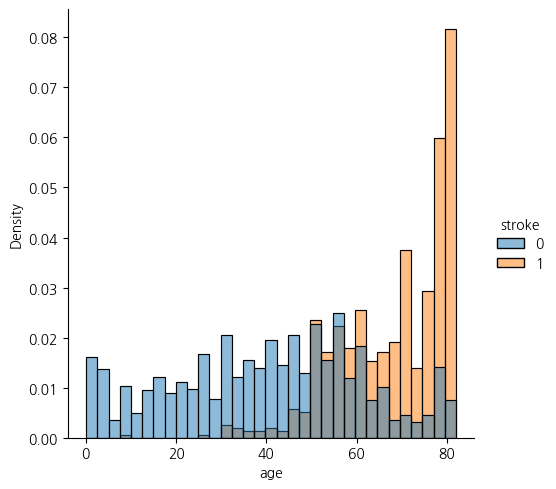

In [7]:
sns.displot(data=df_train, x='age', hue='stroke', stat='density', common_norm=False)

<AxesSubplot:xlabel='stroke', ylabel='age'>

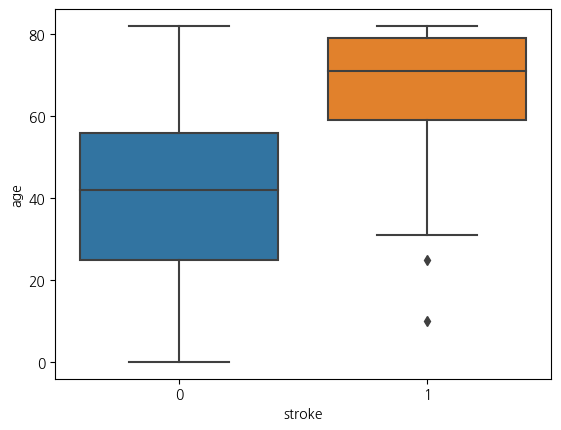

In [8]:
sns.boxplot(y='age', x='stroke', data=df_train)

avg_glucose_level이 높은 사람들에서 stroke이 다수 발생  
stroke을 구분해서 봤을 때 이상치가 많긴 하지만 avg_glucose_level이 높은 사람이 stroke도 많이 일어나기 때문에 이상치를 제거하는 것이 좋은 방법일지는 모르겠음

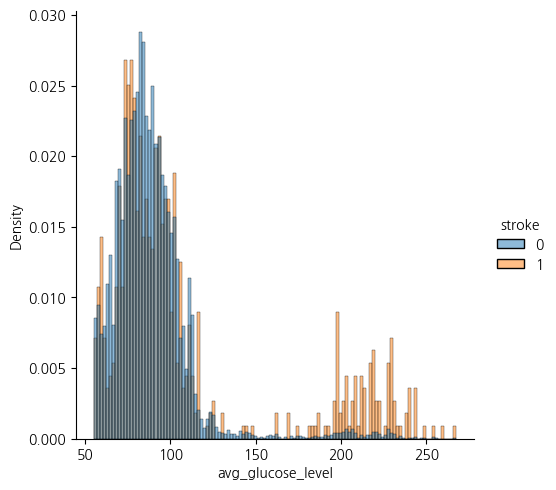

In [9]:
sns.displot(data=df_train, x='avg_glucose_level', hue='stroke', stat='density', common_norm=False)

<AxesSubplot:xlabel='stroke', ylabel='avg_glucose_level'>

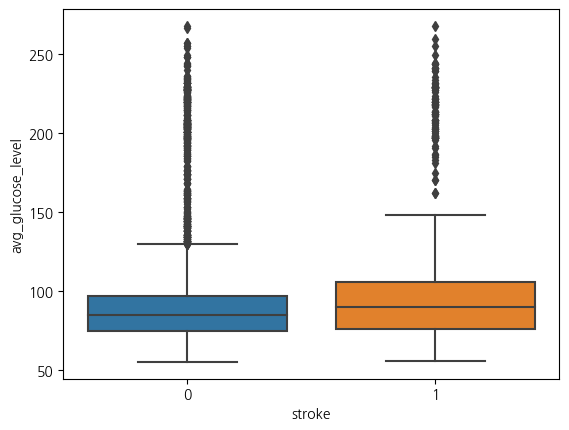

In [10]:
sns.boxplot(y='avg_glucose_level', x='stroke', data=df_train)

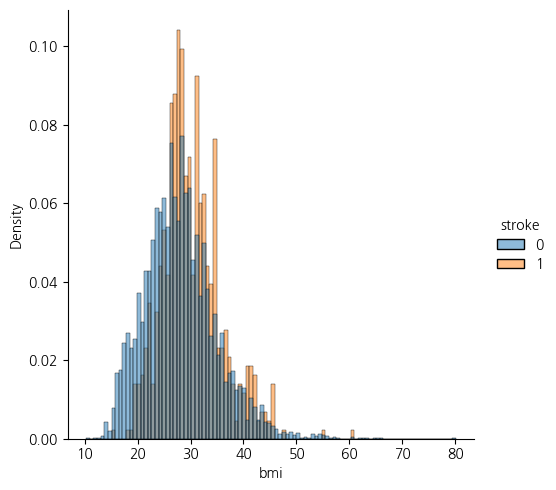

In [11]:
sns.displot(data=df_train, x='bmi', hue='stroke', stat='density', common_norm=False)

<AxesSubplot:xlabel='stroke', ylabel='bmi'>

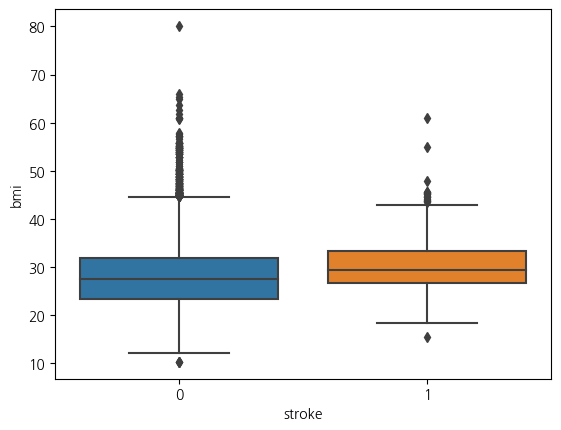

In [12]:
sns.boxplot(y='bmi', x='stroke', data=df_train)

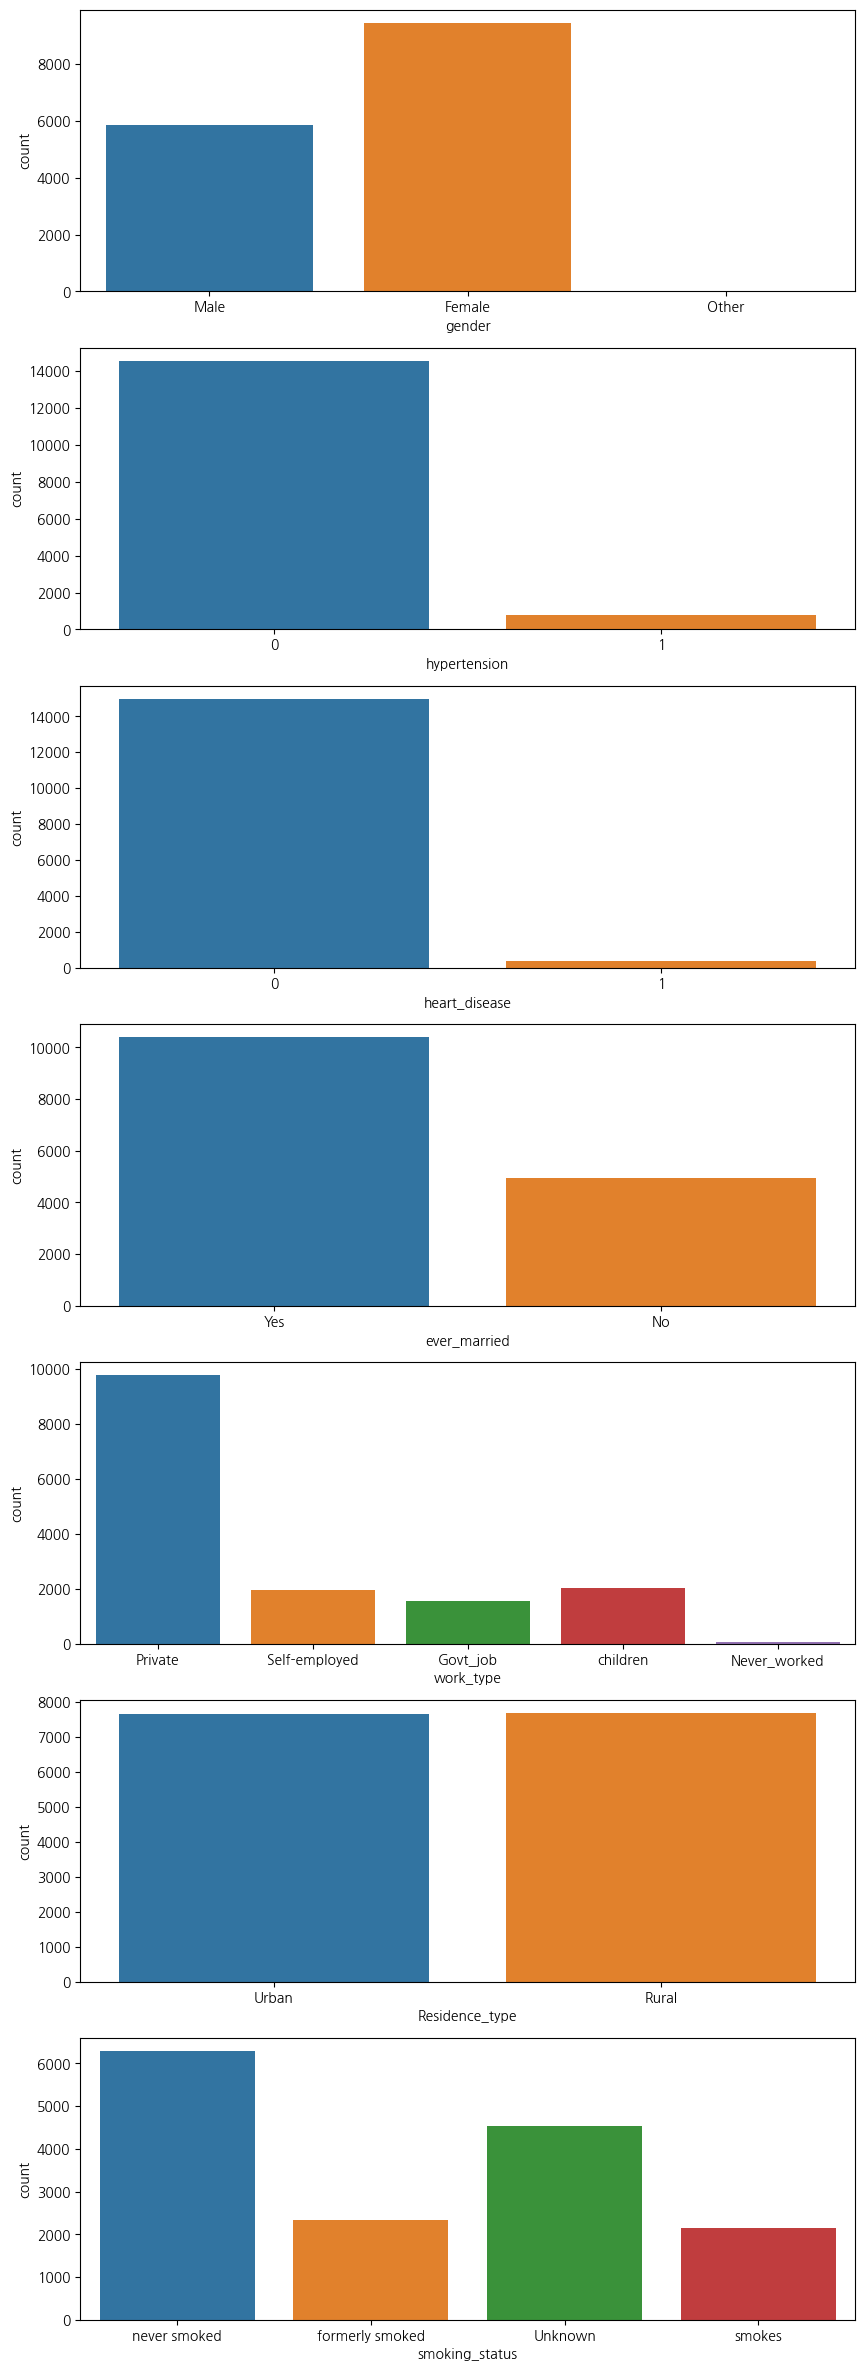

In [13]:
plt.figure(figsize=(10,30))
for idx, feat in enumerate(cat_features):
    plt.subplot(7,1,idx+1)
    sns.countplot(df_train[feat])

gender('Other')과 work_type('Never_worked')는 소수이므로 삭제해도 괜찮을 것 같다

In [26]:
for idx, feat in enumerate(cat_features):
    print(df_train[feat].value_counts(), '\n')

Female    9446
Male      5857
Other        1
Name: gender, dtype: int64 

0    14543
1      761
Name: hypertension, dtype: int64 

0    14947
1      357
Name: heart_disease, dtype: int64 

Yes    10385
No      4919
Name: ever_married, dtype: int64 

Private          9752
children         2038
Self-employed    1939
Govt_job         1533
Never_worked       42
Name: work_type, dtype: int64 

Rural    7664
Urban    7640
Name: Residence_type, dtype: int64 

never smoked       6281
Unknown            4543
formerly smoked    2337
smokes             2143
Name: smoking_status, dtype: int64 



In [28]:
pd.crosstab(df_train['gender'], df_train['stroke'], margins=True)

stroke,0,1,All
gender,,,
Female,9078,368,9446
Male,5593,264,5857
Other,1,0,1
All,14672,632,15304


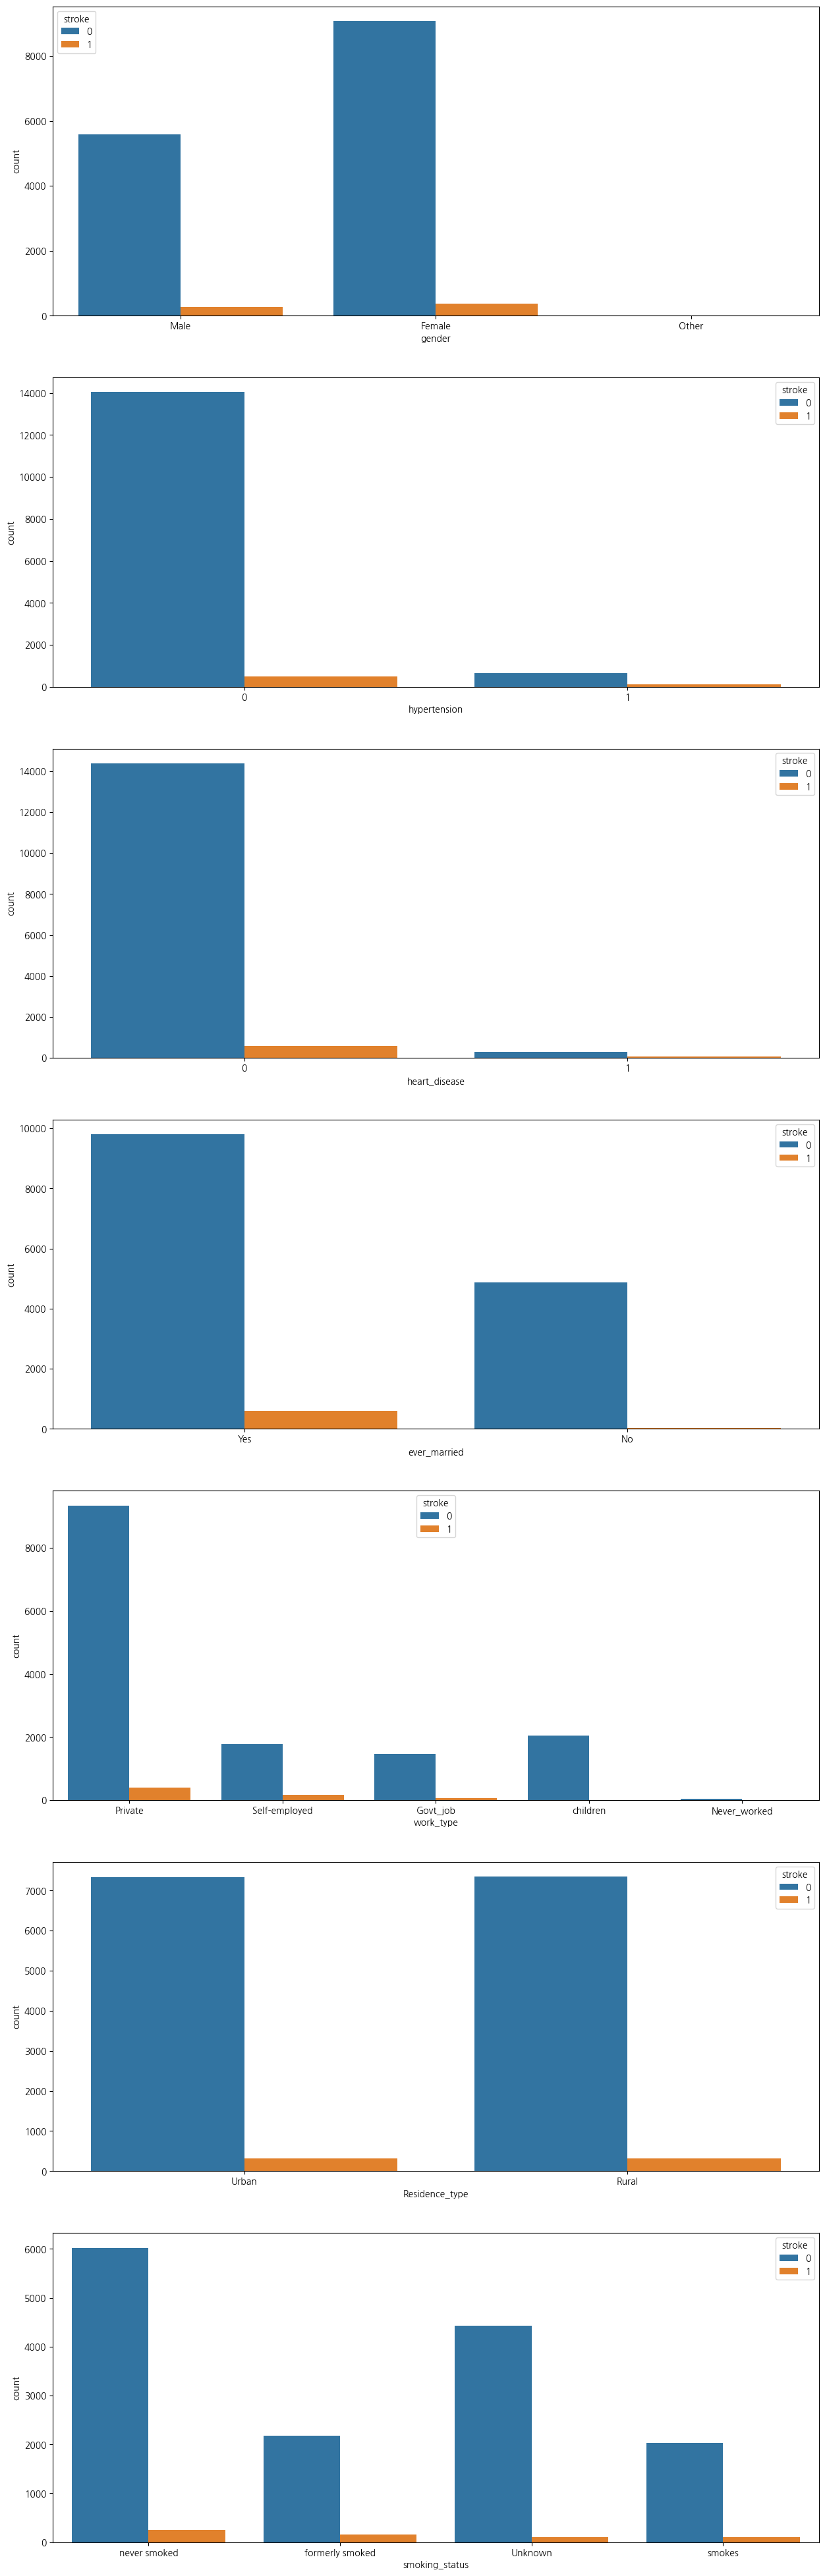

In [15]:
plt.figure(figsize=(15,50))
for idx, feat in enumerate(cat_features):
    plt.subplot(7,1,idx+1)
    sns.countplot(data=df_train, x=feat, hue='stroke')

### 각 categorical feature별 stroke 확률

### gender

남성에서 더 stroke 확률이 높음

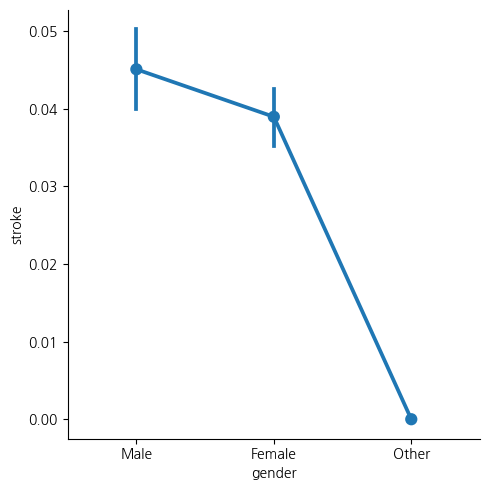

In [16]:
sns.catplot(data=df_train, x=cat_features[0], y='stroke', kind='point')

### age

In [33]:
df_train['age'].max(), df_train['age'].min(), df_train['age'].mean()

(82.0, 0.08, 41.41770778881335)

<AxesSubplot:ylabel='age'>

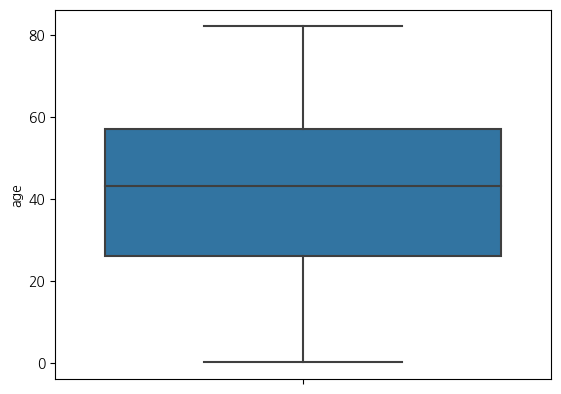

In [39]:
sns.boxplot(data=df_train, y='age')

In [35]:
df_train[df_train['age']==0.08]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3071,3071,Male,0.08,0,0,No,children,Rural,73.33,17.4,Unknown,0
3137,3137,Male,0.08,0,0,No,children,Urban,75.93,14.8,Unknown,0
4155,4155,Female,0.08,0,0,Yes,Private,Urban,79.33,33.2,Unknown,0
4738,4738,Male,0.08,0,0,No,children,Urban,72.01,19.5,Unknown,0
7278,7278,Male,0.08,0,0,No,children,Urban,86.32,16.6,Unknown,0
7579,7579,Male,0.08,0,0,No,children,Rural,80.08,18.1,Unknown,0


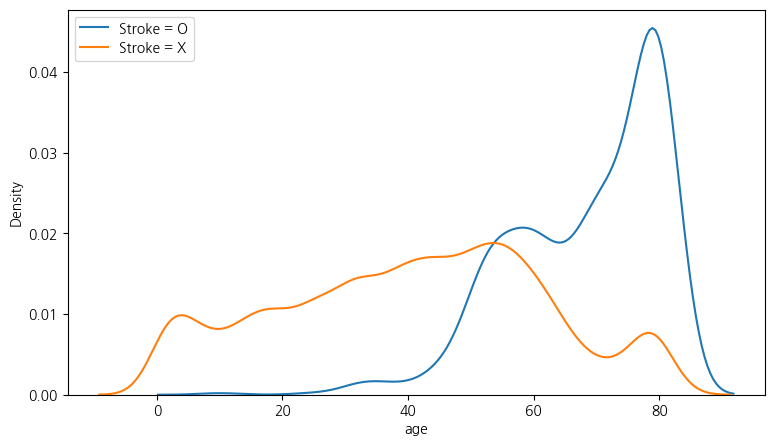

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(df_train[df_train['stroke'] == 1]['age'], ax = ax)
sns.kdeplot(df_train[df_train['stroke'] == 0]['age'], ax = ax)
plt.legend(['Stroke = O', 'Stroke = X'])
plt.show()

In [38]:
df_train[df_train['age']>80]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
57,57,Female,82.0,1,0,Yes,Private,Urban,73.19,33.5,never smoked,0
93,93,Male,81.0,0,0,Yes,Self-employed,Rural,77.96,26.0,formerly smoked,0
155,155,Male,81.0,0,0,Yes,Self-employed,Rural,60.98,26.7,Unknown,1
186,186,Male,82.0,0,1,No,Self-employed,Urban,101.57,24.3,Unknown,0
493,493,Female,81.0,0,0,Yes,Private,Rural,99.44,33.9,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14931,14931,Male,82.0,0,0,Yes,Private,Urban,74.09,33.7,Unknown,0
14965,14965,Male,82.0,1,0,Yes,Self-employed,Urban,81.54,28.4,never smoked,0
15172,15172,Female,82.0,1,1,Yes,Private,Rural,68.80,26.8,smokes,1
15246,15246,Male,81.0,0,0,Yes,Self-employed,Rural,95.84,23.4,Unknown,1


In [46]:
print(df_train['stroke'].value_counts())
print('\nstroke 비율:')
print(df_train['stroke'].value_counts()[1] / df_train['stroke'].value_counts()[0])

0    14672
1      632
Name: stroke, dtype: int64

stroke 비율:
0.0430752453653217


80세 이상 stroke 비율:
0.5673758865248227


<AxesSubplot:xlabel='stroke', ylabel='count'>

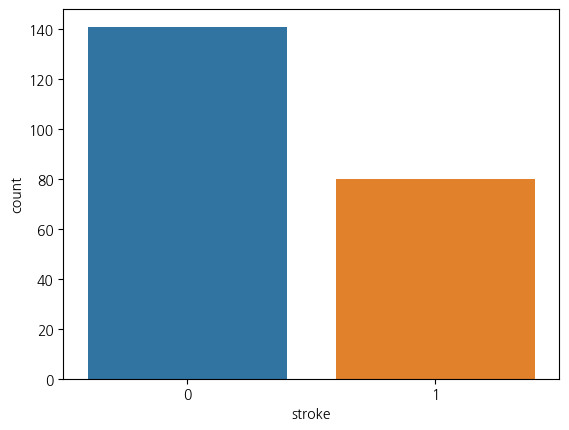

In [48]:
print('80세 이상 stroke 비율:')
print(df_train[df_train['age']>80]['stroke'].value_counts()[1] 
      / df_train[df_train['age']>80]['stroke'].value_counts()[0]) 
sns.countplot(data=df_train[df_train['age']>80], x='stroke')

### hypertension, heart_disease

hypertension, heart_disease가 있는 사람들한테서 stroke 확률이 높음

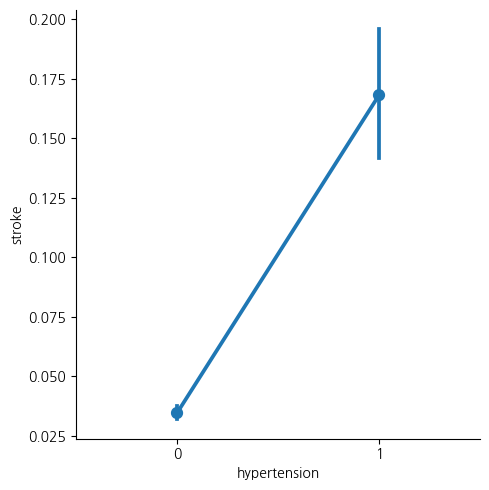

In [17]:
sns.catplot(data=df_train, x=cat_features[1], y='stroke', kind='point')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(df_train[df_train['stroke'] == 1]['age'], ax = ax)
sns.kdeplot(df_train[df_train['stroke'] == 0]['age'], ax = ax)
plt.legend(['Stroke = O', 'Stroke = X'])
plt.show()

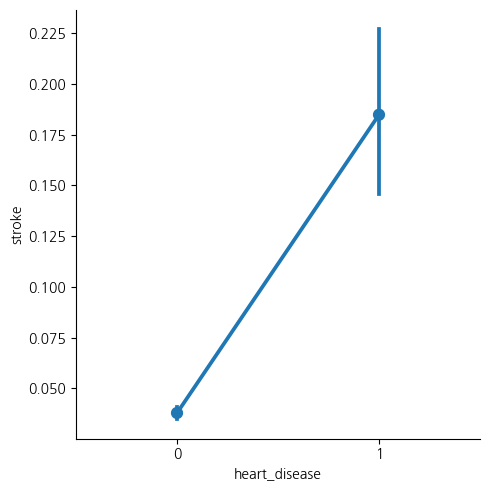

In [18]:
sns.catplot(data=df_train, x=cat_features[2], y='stroke', kind='point')

### ever_married

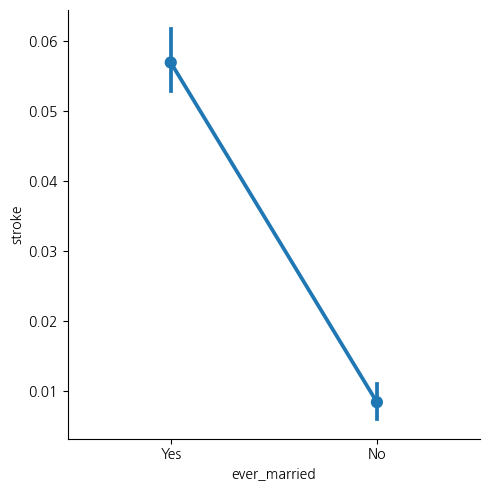

In [19]:
sns.catplot(data=df_train, x=cat_features[3], y='stroke', kind='point')

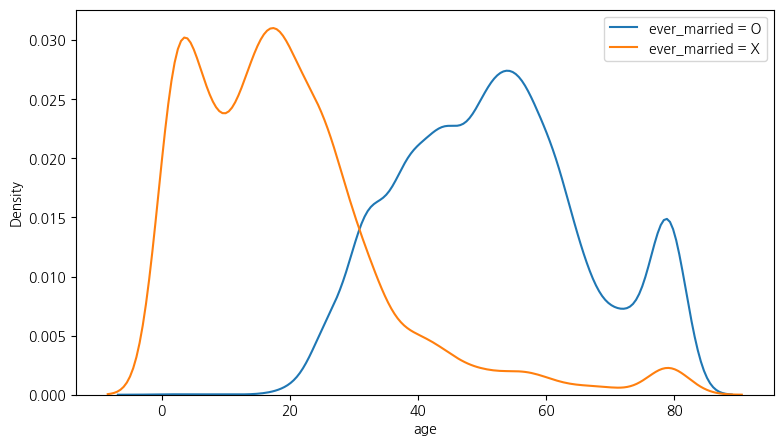

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(df_train[df_train['ever_married'] == 'Yes']['age'], ax = ax)
sns.kdeplot(df_train[df_train['ever_married'] == 'No']['age'], ax = ax)
plt.legend(['ever_married = O', 'ever_married = X'])
plt.show()

work_type이 Self-employed인 사람들한테서 stroke 확률이 높음  

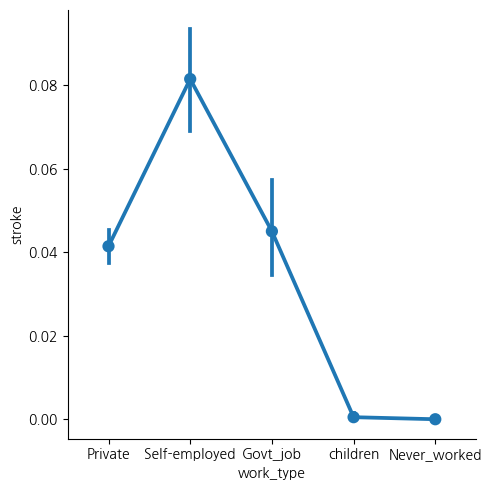

In [20]:
sns.catplot(data=df_train, x=cat_features[4], y='stroke', kind='point')

Residence_type은 상관관계가 없어보임

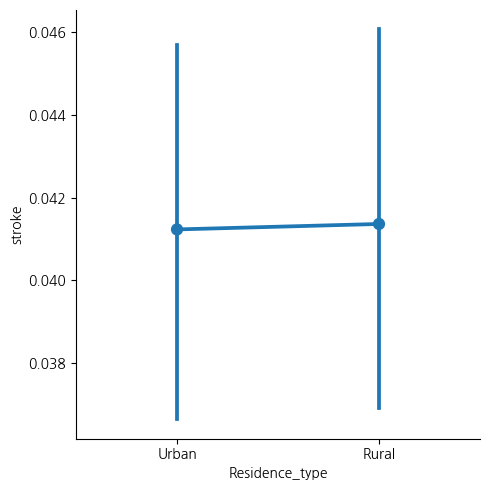

In [21]:
sns.catplot(data=df_train, x=cat_features[5], y='stroke', kind='point')

smoking 경험이 있거나 현재 smoking 상태이면 stroke 확률이 높음

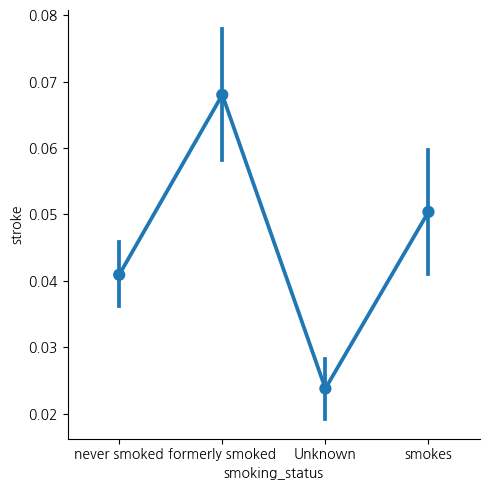

In [22]:
sns.catplot(data=df_train, x=cat_features[6], y='stroke', kind='point')

## Feature간 Correlation

<AxesSubplot:xlabel='hypertension', ylabel='age'>

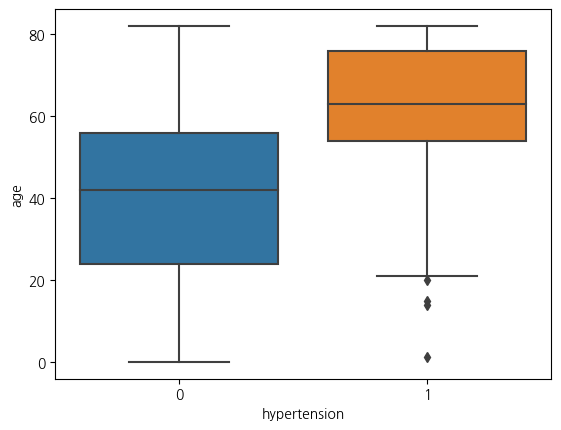

In [23]:
sns.boxplot(data=df_train, y='age', x='hypertension')

<AxesSubplot:xlabel='hypertension', ylabel='avg_glucose_level'>

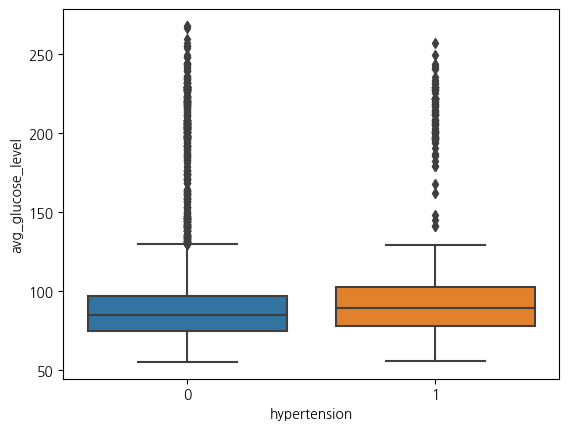

In [24]:
sns.boxplot(data=df_train, y='avg_glucose_level', x='hypertension')

<AxesSubplot:xlabel='hypertension', ylabel='count'>

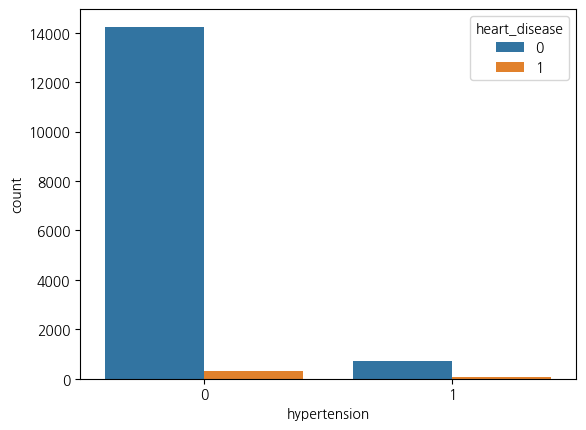

In [25]:
sns.countplot(data=df_train, x='hypertension', hue='heart_disease')

## Heapmap
EDA 결과로 봤을 때는 stroke과 age의 상관관계가 커보임

<AxesSubplot:>

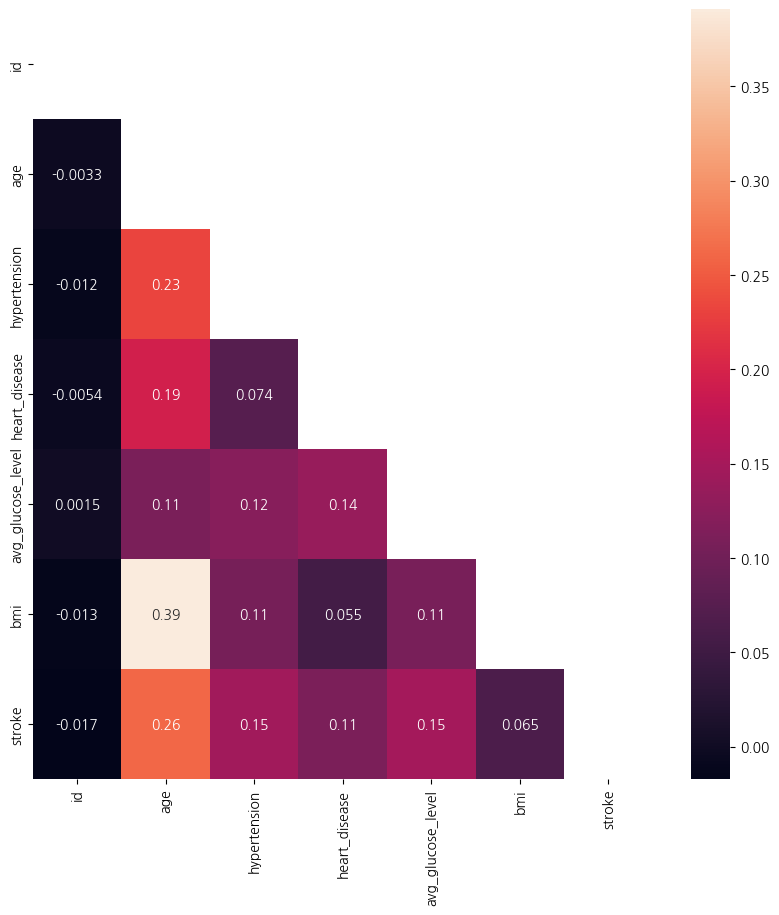

In [56]:
plt.figure(figsize=(10,10))
cor = df_train.corr()
mask = np.triu(np.ones_like(cor, dtype=bool))
sns.heatmap(cor, annot=True, mask=mask)

## Modeling

labeling하기
- gender : 'Other' drop
- work_type : 'children' drop
- smoking_status : 'Unknown' drop

In [89]:
spe_score = make_scorer(recall_score, pos_label=0)
sen_score = make_scorer(recall_score, pos_label=1)

In [73]:
train_DF = df_train.copy()
test_DF = df_test.copy()

train_dummies = pd.get_dummies(train_DF.loc[:,['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']])
train_dummies = train_dummies.drop(columns = ['gender_Other', 'work_type_children', 'ever_married_No',
                                              'smoking_status_Unknown'])

X = train_DF.drop(columns=['id', 'gender', 'ever_married', 'work_type', 'Residence_type',
                       'smoking_status', 'stroke'], axis=1)
X = pd.concat([X, train_dummies], axis=1)
# X_train = X_train.drop(['id', 'gender', 'ever_married', 'work_type', 'Residence_type'], axis=1)
y = train_DF['stroke']

test_dummies = pd.get_dummies(test_DF[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']])
test_dummies = test_dummies.drop(columns = ['gender_Other', 'work_type_children', 'ever_married_No',
                                            'smoking_status_Unknown'])
X_test = test_DF.drop(columns=['id', 'gender', 'ever_married', 'work_type', 
                               'smoking_status'], axis=1)
X_test = pd.concat([test_DF, test_dummies], axis=1)
X_test = X_test.drop(['id', 'gender', 'ever_married', 'work_type', 'smoking_status', 'Residence_type'], axis=1)

In [74]:
X

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,28.0,0,0,79.53,31.1,0,1,1,0,0,1,0,0,1,0,1,0
1,33.0,0,0,78.44,23.9,0,1,1,0,0,1,0,1,0,1,0,0
2,42.0,0,0,103.00,40.3,1,0,1,0,0,1,0,1,0,0,0,0
3,56.0,0,0,64.87,28.8,0,1,1,0,0,1,0,0,1,0,1,0
4,24.0,0,0,73.36,28.8,1,0,0,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15299,22.0,0,0,72.63,19.5,1,0,0,1,0,0,0,0,1,0,1,0
15300,46.0,1,0,101.19,32.1,1,0,1,0,0,1,0,0,1,0,1,0
15301,75.0,0,0,87.69,26.2,1,0,1,0,0,0,1,0,1,0,1,0
15302,46.0,0,0,101.13,22.5,0,1,1,0,0,1,0,1,0,0,0,0


In [97]:
def train_evaluate(X, y, model, roc=False):
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

    auc_scores = []
    for train_ix, test_ix in skf.split(X, y):

        ## Splitting the data 
        X_train, X_val = X.iloc[train_ix], X.iloc[test_ix]
        y_train, y_val = y.iloc[train_ix], y.iloc[test_ix]

    #     ## Scaling the data
    #     X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
    #     X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X.columns)

        ## Building logistic model
        model.fit(X_train, y_train)

        pred_val = model.predict_proba(X_val)[:,1]
        pred_train = model.predict_proba(X_train)[:,1]
#         pred_test = model.predict_proba(X_test)[:,1]

        auc_scores.append(roc_auc_score(y_val, pred_val))

    print(str(model).split('(')[0])
    print('mean auc score :', np.mean(auc_scores))
    print(auc_scores, '\n')
    
    if roc:
        fig, ax = plt.subplots(1, 1, figsize=(8,7))
        train_roc = RocCurveDisplay.from_predictions(y_train, pred_train, ax=ax)
        val_roc = RocCurveDisplay.from_predictions(y_val, pred_val, ax=ax)
        plt.show()

In [65]:
# original
train_evaluate(X, y)

LogisticRegression
mean auc score : 0.8838131705293684
[0.8813120250939672, 0.8826884075606392, 0.8952466064441331, 0.8773489203420124, 0.8824698932060896] 

RandomForestClassifier
mean auc score : 0.8815746791709053
[0.8822990184148616, 0.8836929774749196, 0.8919671084059277, 0.8778749282106608, 0.8720393633481567] 

LGBMClassifier
mean auc score : 0.8764288026019684
[0.8782388253427436, 0.8812619994050999, 0.8774495596025957, 0.8716218754864231, 0.8735717531729802] 

XGBClassifier
mean auc score : 0.8530201088682228
[0.8608069008409724, 0.8676293231659502, 0.8477904985803155, 0.8549318605113012, 0.8339419612425748] 

SVC
mean auc score : 0.8788711848798838
[0.8763770584894945, 0.8785538519780427, 0.8908748369643978, 0.8714984246601076, 0.877051752307376] 



In [95]:
models = [
          LogisticRegression(class_weight={0:0.1, 1:0.9}, random_state=42, n_jobs=-1),
          RandomForestClassifier(n_estimators=500, max_depth=5, class_weight={0:0.1, 1:0.9}, random_state=99),
          LGBMClassifier(n_estimators=100, max_depth=5, class_weight={0:0.1, 1:0.9}, random_state=42),
#           LGBMClassifier(n_estimators=50, max_depth=-1, class_weight={0:0.1, 1:0.9}, random_state=42),
          XGBClassifier(n_estimators=100, max_depth=5, random_state=42),
          SVC(class_weight={0:0.1, 1:0.9}, probability=True, random_state=42)
         ]

In [80]:
# drop ever_married
X_drop_married = X.drop(['ever_married_Yes'], axis=1)

for model in models:
    train_evaluate(X_drop_married, y, model)

LogisticRegression
mean auc score : 0.883767312304272
[0.8817771287958681, 0.8831724399015711, 0.8941113955847545, 0.8783633640886913, 0.8814122331504745] 

RandomForestClassifier
mean auc score : 0.8823786324364045
[0.883461777669614, 0.8850612476677213, 0.8870237079260798, 0.8792865615724414, 0.8770598673461659] 

LGBMClassifier
mean auc score : 0.8781267634369136
[0.8808361050269058, 0.8822151915848679, 0.8773261087762803, 0.8714071783971788, 0.8788492333993356] 

XGBClassifier
mean auc score : 0.8452093008030749
[0.8554014223520185, 0.8606324869527594, 0.8355339784980863, 0.8442560477486326, 0.8302225684638772] 

SVC
mean auc score : 0.8788226005297737
[0.876185068007896, 0.8785673724344935, 0.8908131115512401, 0.8715011083737232, 0.877046342281516] 



In [100]:
X_drop_3 = X_drop_married.drop(['Residence_type_Rural', 'Residence_type_Urban'] ,axis=1)
for model in models:
    train_evaluate(X_drop_3, y, model)

LogisticRegression
mean auc score : 0.8834167016308158
[0.8808144722965847, 0.8827992753035342, 0.8933975277630174, 0.8784787637741601, 0.8815934690167819] 

RandomForestClassifier
mean auc score : 0.8813131863253318
[0.884835456044996, 0.8832670830967253, 0.8856348861300313, 0.8801453499294183, 0.8726831564254878] 

LGBMClassifier
mean auc score : 0.8755322302489084
[0.8762797112030503, 0.8814255969281523, 0.875462269670279, 0.8693380351995877, 0.8751555382434728] 

XGBClassifier
mean auc score : 0.8708955972414184
[0.8782834428490306, 0.8712690300424542, 0.8617136048178028, 0.8743861005104423, 0.8688258079873622] 

SVC
mean auc score : 0.8787005438266791
[0.8758713934182419, 0.878426759687407, 0.8907970092695469, 0.8714044946835633, 0.8770030620746366] 



In [101]:
X_drop_5 = X_drop_3.drop(['work_type_Never_worked', 'gender_Male'] ,axis=1)
for model in models:
    train_evaluate(X_drop_5, y, model)

LogisticRegression
mean auc score : 0.8837652374041636
[0.8820042724642385, 0.8824504475271086, 0.8941221304392165, 0.8789994042155773, 0.8812499323746769] 

RandomForestClassifier
mean auc score : 0.8828665955335169
[0.8852221410994836, 0.8863308185284335, 0.8860186571770553, 0.8805157024083646, 0.8762456584542474] 

LGBMClassifier
mean auc score : 0.8754468881559339
[0.8762797112030503, 0.8814255969281523, 0.875462269670279, 0.868911324734715, 0.8751555382434728] 

XGBClassifier
mean auc score : 0.8708972074695875
[0.8782834428490306, 0.8712690300424542, 0.8617189722450338, 0.8743887842240579, 0.8688258079873621] 

SVC
mean auc score : 0.8784436699395428
[0.8752737892431248, 0.8782104323841973, 0.8906252515981515, 0.8712058998760124, 0.8769029765962281] 



LogisticRegression
mean auc score : 0.883767312304272
[0.8817771287958681, 0.8831724399015711, 0.8941113955847545, 0.8783633640886913, 0.8814122331504745] 



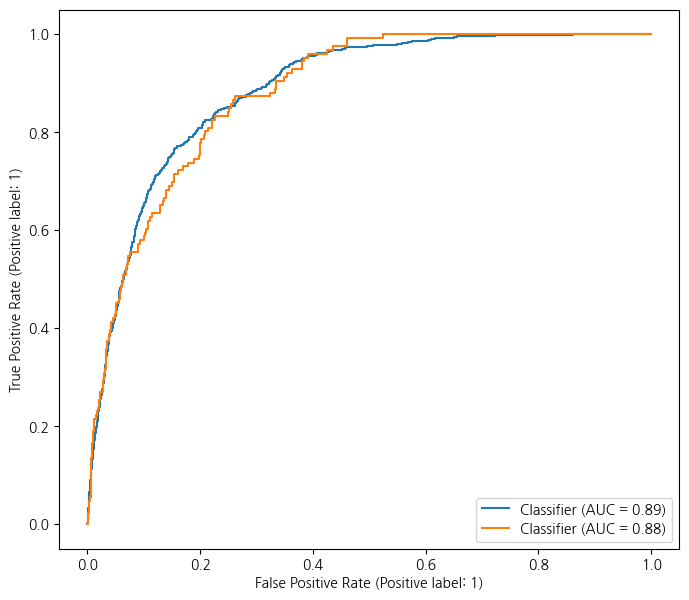

In [87]:
model = models[0]
train_evaluate(X_drop_married, y, model)

RandomForestClassifier
mean auc score : 0.8823786324364045
[0.883461777669614, 0.8850612476677213, 0.8870237079260798, 0.8792865615724414, 0.8770598673461659] 



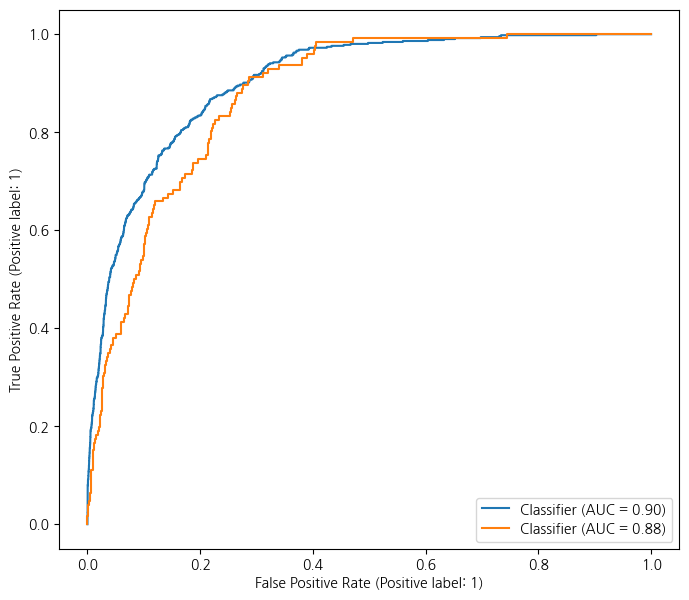

In [90]:
model = models[1]
train_evaluate(X_drop_married, y, model)

LGBMClassifier
mean auc score : 0.8781267634369136
[0.8808361050269058, 0.8822151915848679, 0.8773261087762803, 0.8714071783971788, 0.8788492333993356] 



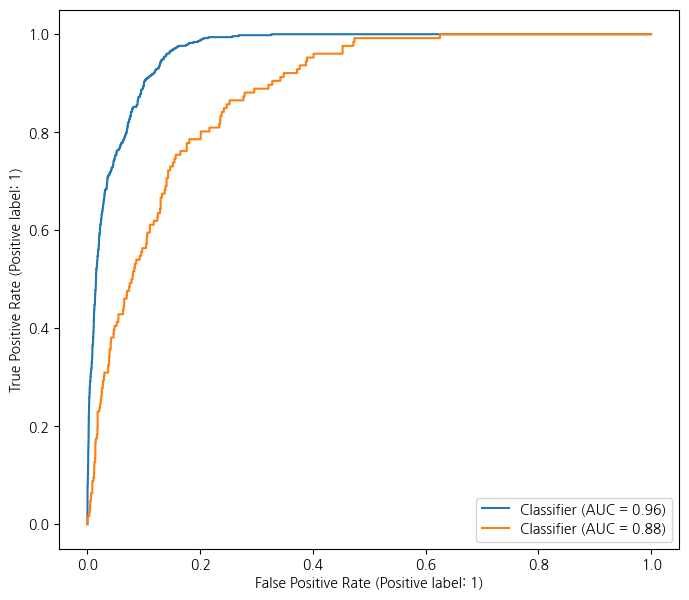

In [92]:
model = models[2]
train_evaluate(X_drop_married, y, model)

XGBClassifier
mean auc score : 0.8715508014376925
[0.8738676617722614, 0.8752940699278008, 0.8643060721704265, 0.870926793659995, 0.8733594096579782] 



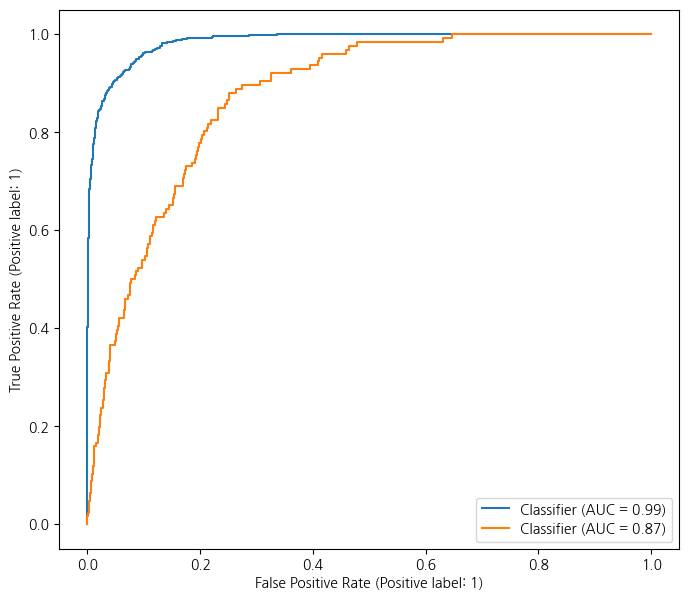

In [96]:
model = models[3]
train_evaluate(X_drop_married, y, model)

SVC
mean auc score : 0.8788226005297737
[0.876185068007896, 0.8785673724344935, 0.8908131115512401, 0.8715011083737232, 0.877046342281516] 



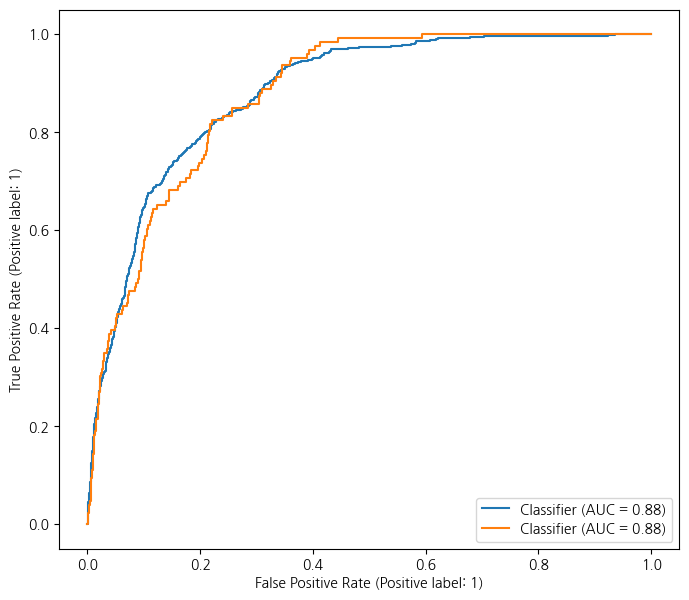

In [94]:
model = models[4]
train_evaluate(X_drop_married, y, model)

<AxesSubplot:>

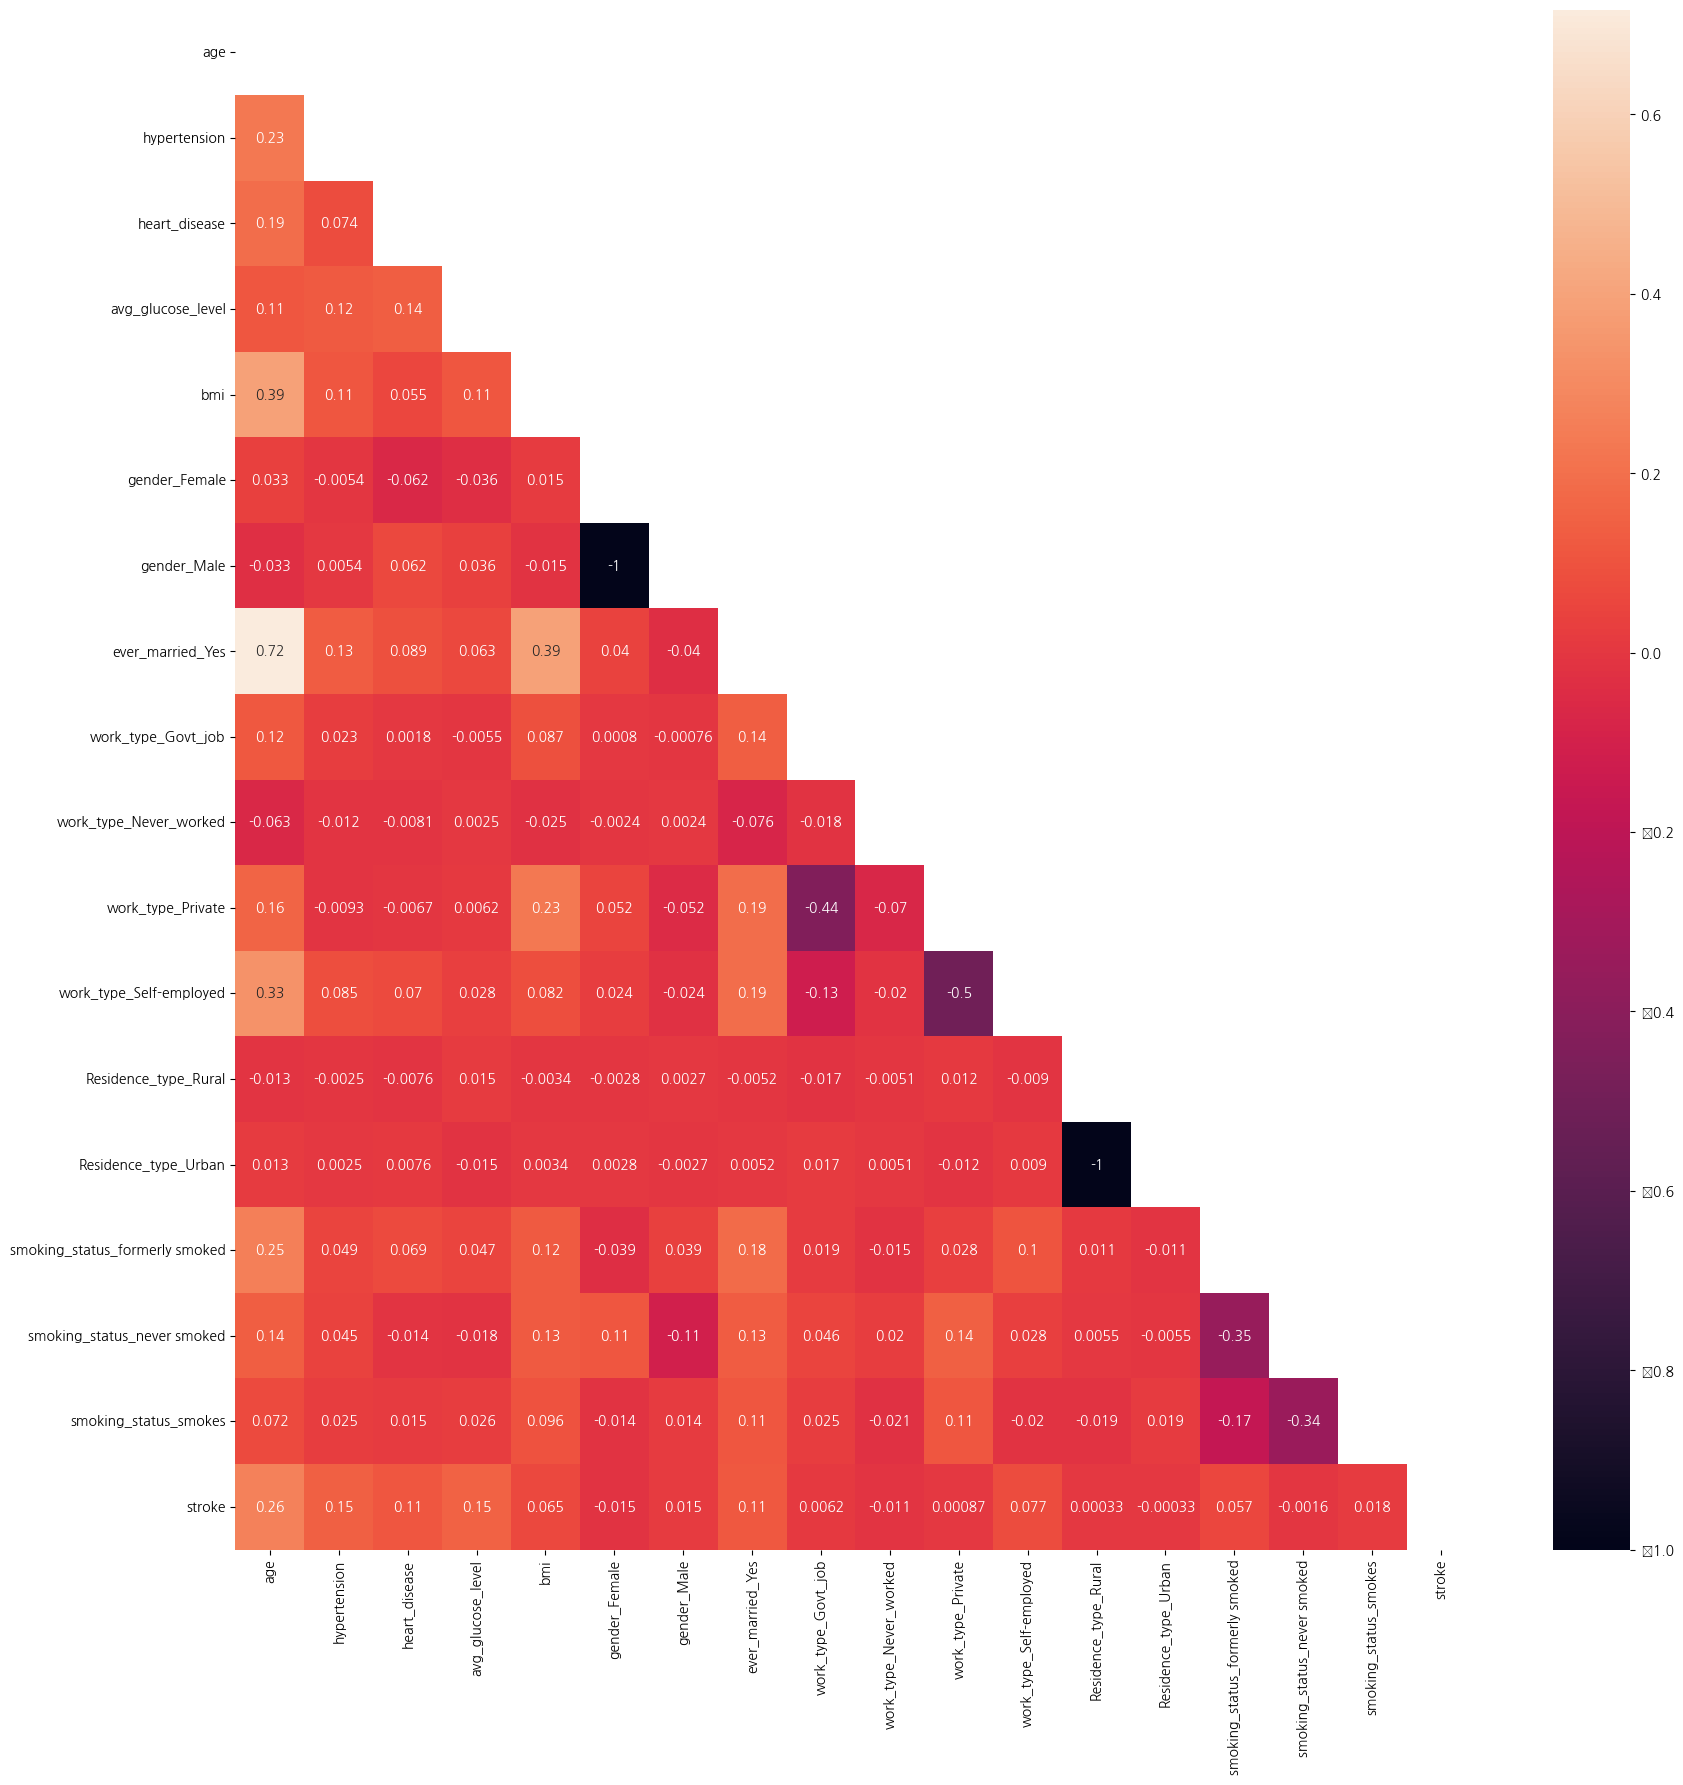

In [131]:
df = pd.concat([X_train, y_train], axis=1)
plt.figure(figsize=(20,20))
cor = df.corr()
mask = np.triu(np.ones_like(cor, dtype=bool))
sns.heatmap(cor, annot=True, mask=mask)

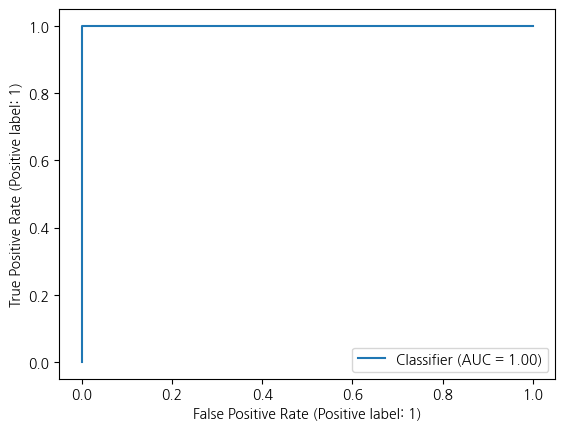

In [117]:
train_roc = RocCurveDisplay.from_predictions(y_train, y_pred_proba_train)
train_roc